# Full changesets

## Goals
- Come up with a list of taggers that will make the model an effective flagger

## Workflow
- Download the latest 1000 reviewed changesets from osm full features
- Use the 500 (250 harmful and 250 not harmful) as the training set and the other for testing.
- For every harmful changeset, understand why it was harmful
    - Convert why the changeset was harmful into a feature
- Train a model with the feature
- Predict label for other 500 changesets

## Notes
- Try a lot of taggers - 100 or even a 1000
- What taggers when used by gabbar has the best performance

## Train and test ML model

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
changesets = pd.read_csv('v2/changesets-with-features.csv')
print('Total changesets: {}'.format(changesets.shape[0]))

changesets = changesets.dropna()
print('Changesets after dropna: {}'.format(changesets.shape[0]))

# Vectorize changeset_editor column.
changesets = pd.concat([changesets, pd.get_dummies(changesets[['changeset_editor']])], axis=1)

changesets = changesets.sort('changeset_id')
changesets.sample(5)

Total changesets: 4243
Changesets after dropna: 4046


,changeset_id,harmful,features_created,features_modified,features_deleted,user_id,user_name,user_changesets,user_features,changeset_bbox_area,...,tourism,waterway,changeset_editor_JOSM,changeset_editor_MAPS.ME,changeset_editor_OsmAnd,changeset_editor_Potlatch,changeset_editor_Vespucci,changeset_editor_gnome,changeset_editor_iD,changeset_editor_other
1516,47419165,False,0,1,0,18069,Claudius Henrichs,9390.0,809795.0,4.815815e+02,...,0,0,0,0,0,0,0,0,0,1
2731,47367096,False,5,0,0,339912,markbegbie,1333.0,329544.0,1.372921e+02,...,0,0,1,0,0,0,0,0,0,0
791,47443451,False,0,1,0,2179792,SeFaireConnaitre,15038.0,15568.0,0.000000e+00,...,0,0,0,0,0,0,0,0,0,1
1138,47431643,False,33,18,1,87286,Aric,1752.0,87843.0,3.782895e+05,...,0,0,1,0,0,0,0,0,0,0
4216,46209067,True,0,221,0,3012156,eagleeye_zh,328.0,20204.0,2.620446e+07,...,0,0,0,0,0,0,0,0,1,0


In [4]:
harmful_changesets = changesets[changesets['harmful'] == True]
print('Changesets harmful: {}'.format(harmful_changesets.shape))


not_harmful_changesets = changesets[changesets['harmful'] == False]
print('Changesets not harmful: {}'.format(not_harmful_changesets.shape))

Changesets harmful: (339, 51)
Changesets not harmful: (3707, 51)


In [5]:
features = changesets.columns.values
non_numerical_features = np.array(['changeset_id', 'harmful', 'user_id', 'user_name', 'changeset_editor'])
features = np.setdiff1d(features, non_numerical_features)
print('Total features: {}\n'.format(len(features)))
print(features)
changesets[features].head()

Total features: 46

['aerialway' 'aeroway' 'amenity' 'barrier' 'boundary' 'building'
 'changeset_bbox_area' 'changeset_editor_JOSM' 'changeset_editor_MAPS.ME'
 'changeset_editor_OsmAnd' 'changeset_editor_Potlatch'
 'changeset_editor_Vespucci' 'changeset_editor_gnome' 'changeset_editor_iD'
 'changeset_editor_other' 'craft' 'emergency' 'feature_version_sum'
 'features_created' 'features_deleted' 'features_modified' 'geological'
 'geometry_modifications' 'highway' 'historic' 'landuse' 'leisure'
 'man_made' 'military' 'natural' 'node_count' 'office' 'place' 'power'
 'property_modifications' 'public_transport' 'railway' 'relation_count'
 'route' 'shop' 'sport' 'tourism' 'user_changesets' 'user_features'
 'waterway' 'way_count']


,aerialway,aeroway,amenity,barrier,boundary,building,changeset_bbox_area,changeset_editor_JOSM,changeset_editor_MAPS.ME,changeset_editor_OsmAnd,...,railway,relation_count,route,shop,sport,tourism,user_changesets,user_features,waterway,way_count
4242,0,0,0,0,0,2,4.516499e+06,0,0,0,...,0,1,0,0,0,0,3.0,2509.0,0,334
4241,0,0,0,0,0,0,1.137263e+05,0,0,0,...,0,0,0,0,0,0,12.0,597.0,0,18
4240,0,0,0,0,0,0,6.222359e+05,0,0,0,...,0,0,0,0,0,0,284.0,18967.0,0,1
4239,0,0,0,0,0,0,7.104121e+07,0,1,0,...,0,0,0,0,0,0,2.0,4.0,0,1
4238,0,0,0,0,0,0,5.183463e+05,0,0,0,...,0,0,0,0,0,0,56.0,6628.0,0,6


In [6]:
changesets[features].describe()

,aerialway,aeroway,amenity,barrier,boundary,building,changeset_bbox_area,changeset_editor_JOSM,changeset_editor_MAPS.ME,changeset_editor_OsmAnd,...,railway,relation_count,route,shop,sport,tourism,user_changesets,user_features,waterway,way_count
count,4046.0,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4.046000e+03,4046.000000,4046.000000,4046.000000,...,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4.046000e+03,4046.000000,4046.000000
mean,0.0,0.061542,0.516807,0.097380,0.693277,5.494810,5.723922e+11,0.313643,0.072170,0.001977,...,0.995304,1.644340,0.142363,0.192783,0.067968,0.093178,7848.266189,7.871847e+05,0.290657,13.504696
std,0.0,2.315193,2.790871,0.952731,16.093134,28.559877,5.004255e+12,0.464031,0.258801,0.044428,...,47.400038,19.839749,1.078615,1.363630,0.751152,1.009702,19607.090945,2.476289e+06,4.850756,69.155670
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.533986e+02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,3.310000e+02,0.000000,1.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.784529e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,479.000000,9.366000e+03,0.000000,1.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.518447e+05,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5540.000000,4.640430e+05,0.000000,5.000000
max,0.0,141.000000,58.000000,20.000000,723.000000,795.000000,1.233740e+14,1.000000,1.000000,1.000000,...,2950.000000,652.000000,28.000000,41.000000,31.000000,32.000000,280619.000000,3.134736e+07,226.000000,2743.000000


In [7]:
from sklearn.cross_validation import train_test_split

# Feature matrix.
X = changesets[features]

# Target array.
y = changesets['harmful']

# Scale features using RobustScaler which is good for outliers.
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(X)
X = scaler.transform(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, train_size=0.7)
print('Training samples: {}'.format(Xtrain.shape[0]))
print('Testing samples: {}'.format(Xtest.shape[0]))

Training samples: 2832
Testing samples: 1214


/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

# from sklearn.svm import SVC
# model = SVC(kernel='rbf')

# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier()

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=10)

model.fit(Xtrain, ytrain);

# Get predictions.
ymodel = model.predict(Xtest)

In [9]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ymodel))

             precision    recall  f1-score   support

      False       0.91      0.99      0.95      1099
       True       0.19      0.03      0.05       115

avg / total       0.84      0.90      0.86      1214



In [10]:
# Evaluate a score by cross-validation.
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, cv=3)
np.mean(scores)

0.91003263581698424

/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


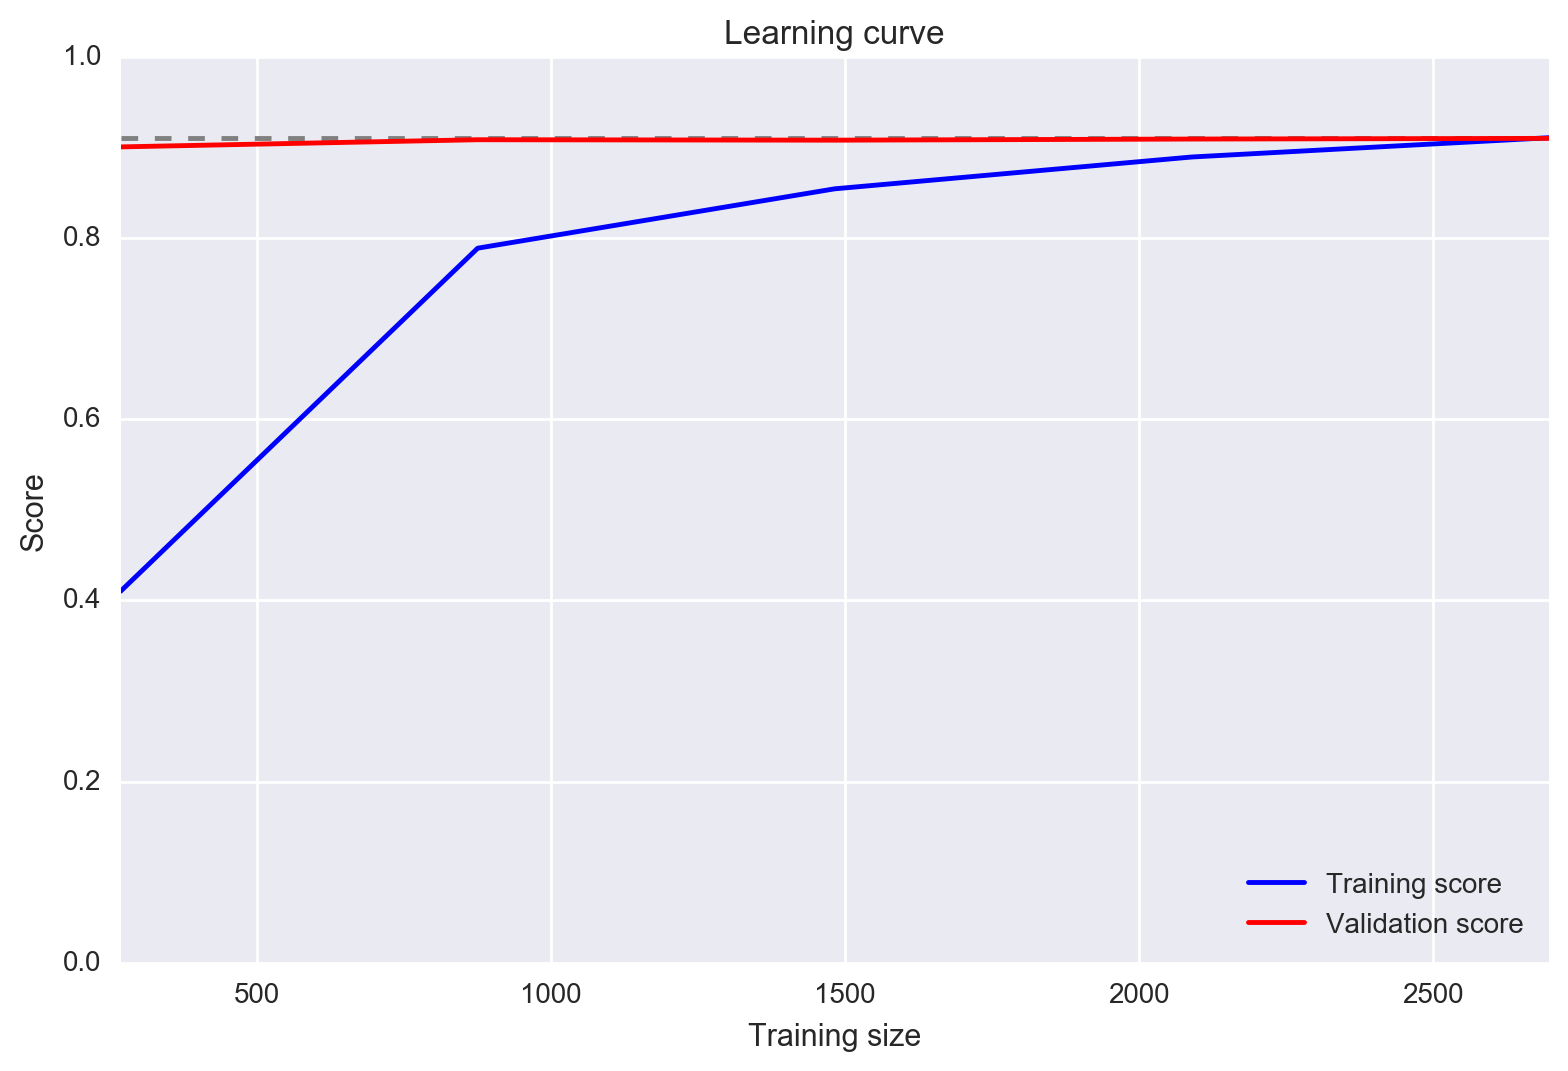

In [11]:
# Learning curve.
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 1)

N, train_lc, val_lc = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, 5))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='Training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='Validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('Training size')
ax.set_ylabel('Score')
ax.set_title('Learning curve')
ax.legend(loc='lower right')

plt.tight_layout()

In [12]:
# Add the predictions as a new column.
changesets['prediction'] = model.predict(scaler.transform(changesets[features]))

In [13]:
from sklearn.metrics import confusion_matrix
np.ravel(confusion_matrix(changesets['harmful'], changesets['prediction']))

array([3669,   38,  325,   14])

In [14]:
print('Predicted true: {}'.format(changesets[changesets['prediction'] == True].shape[0]))
print('Predicted false: {}'.format(changesets[changesets['prediction'] == False].shape[0]))

Predicted true: 52
Predicted false: 3994


In [15]:
booleans = [True, False]
for actual in booleans:
    for prediction in booleans:
        temp = changesets[(changesets['harmful'] == actual) & (changesets['prediction'] == prediction)]
        print('Actual: {}, Prediction: {}, Changesets: {}'.format(actual, prediction, temp.shape[0]))

Actual: True, Prediction: True, Changesets: 14
Actual: True, Prediction: False, Changesets: 325
Actual: False, Prediction: True, Changesets: 38
Actual: False, Prediction: False, Changesets: 3669


In [16]:
changesets[(changesets['harmful'] == False) & (changesets['prediction'] == True)].head()

,changeset_id,harmful,features_created,features_modified,features_deleted,user_id,user_name,user_changesets,user_features,changeset_bbox_area,...,waterway,changeset_editor_JOSM,changeset_editor_MAPS.ME,changeset_editor_OsmAnd,changeset_editor_Potlatch,changeset_editor_Vespucci,changeset_editor_gnome,changeset_editor_iD,changeset_editor_other,prediction
3952,47305710,False,138,19,12,201359,wambacher,9142.0,804780.0,4.843903e+13,...,0,1,0,0,0,0,0,0,0,True
3655,47313206,False,0,89,0,290680,wheelmap_visitor,16517.0,512192.0,5.079043e+13,...,0,0,0,0,0,0,0,0,1,True
3564,47319478,False,75,49,0,5528270,Philip Guston,132.0,8502.0,1.632830e+13,...,0,1,0,0,0,0,0,0,0,True
3500,47321544,False,68,84,45,5528270,Philip Guston,132.0,8502.0,2.970660e+13,...,0,1,0,0,0,0,0,0,0,True
3367,47327516,False,2,20,0,4760005,TeaTime13,1951.0,50658.0,3.075084e+13,...,0,1,0,0,0,0,0,0,0,True


## Filter changesets

In [17]:
# Failing here to prevent the script below from running everytime.
assert False

AssertionError: 

In [ ]:
changesets = pd.read_csv('changesets.csv').drop_duplicates('ID')
harmfuls = 1000
not_harmfuls = 4000
harmful_changesets = changesets[changesets['harmful'] == True].drop_duplicates('user').iloc[:harmfuls]
not_harmful_changesets = changesets[changesets['harmful'] == False].iloc[:not_harmfuls]
not_harmful_changesets.shape
changesets = pd.concat([harmful_changesets, not_harmful_changesets]).sort('ID', ascending=False)
changesets.to_csv('v2/changesets-filtered.csv', index=False)